In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

# Set random seed for reproducibility
np.random.seed(42)

# --- Model Parameters ---
MU_MAX = 0.86980    # 1/h
K_S = 0.000123762    # g/l
Y_XS = 0.435749      # g/g
S_F = 286           # g/l
K_I    = 33           # g/l
k_d    = 0.03        # 1/h

# --- Model parameters estimated using PINN ---
MU_MAX = 0.8564
K_S    = 0.1707
Y_XS   = 0.4066

# Noise parameters
BIOMASS_NOISE = 0.035
SUBSTRATE_NOISE = 0.03

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

T_START = 0
T_END = 10
dt = 0.1  # Time step
time = np.arange(T_START, T_END, dt)

F_min, F_max = 0, 0.1       # Feed bounds [L/h]

# Actual system model with cell death and substrate inhibition
def actual_system(t, y, F):
    X, S, V = y
    S = max(S, 0)
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

# Plant Model
def system_dynamics(t, y, F):
    X, S, V = y
    S = max(S, 0)
    mu = MU_MAX * S / (K_S + S)
    dXdt = mu * X - (F / V) * X
    dSdt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S)
    dVdt = F
    return [dXdt, dSdt, dVdt]

class PID:
    def __init__(self, Kp, Ki, Kd, setpoint=0.0, output_limits=(0.0, 0.1)):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0.0
        self.prev_error = 0.0
        self.output_limits = output_limits

    def update(self, measured_value, dt):
        error = self.setpoint - measured_value  # Remove abs
        derivative = (error - self.prev_error) / dt if dt > 0 else 0.0

        # Propose new integral
        proposed_integral = self.integral + error * dt
        raw_output = (
            self.Kp * error +
            self.Ki * proposed_integral +
            self.Kd * derivative
        )

        # Anti-windup
        output = np.clip(raw_output, *self.output_limits)
        if output == raw_output:
            self.integral = proposed_integral

        self.prev_error = error
        return output

setpoint = 30.0

# Storage
X = X_0
S = S_0
V = V_0
F = 0.0
X_hist = [X_0]
S_hist = [S_0]
V_hist = [V_0]
F_hist = [F]
t_hist = [time[0]]

# PID Controller 
pid = PID(Kp=2, Ki=0.005, Kd=0.005, setpoint=setpoint, output_limits=(0, 0.1))

for i in range(1, len(time)):
    t = time[i-1]
    # Update PID and solve system
    p = pid.update(X, dt)
    p = np.clip(p, F_min, F_max)
    # Solve ODE
    sol_real = solve_ivp(actual_system, [t, t+dt], [X, S, V], args=(p,), method='RK45', t_eval=[t+dt])
    # Add noise to the real system
    sol_real.y[0][1:] += np.random.normal(0, max(0, sol_real.y[0].max()) * BIOMASS_NOISE, size=sol_real.y[0][1:].shape)
    sol_real.y[1][1:] += np.random.normal(0, max(0, sol_real.y[1].max()) * SUBSTRATE_NOISE, size=sol_real.y[1][1:].shape)

    X, S, V = sol_real.y[:,-1]    
    X_hist.append(X)
    S_hist.append(S)
    V_hist.append(V)
    F_hist.append(p)    
    t_hist.append(t + dt)    

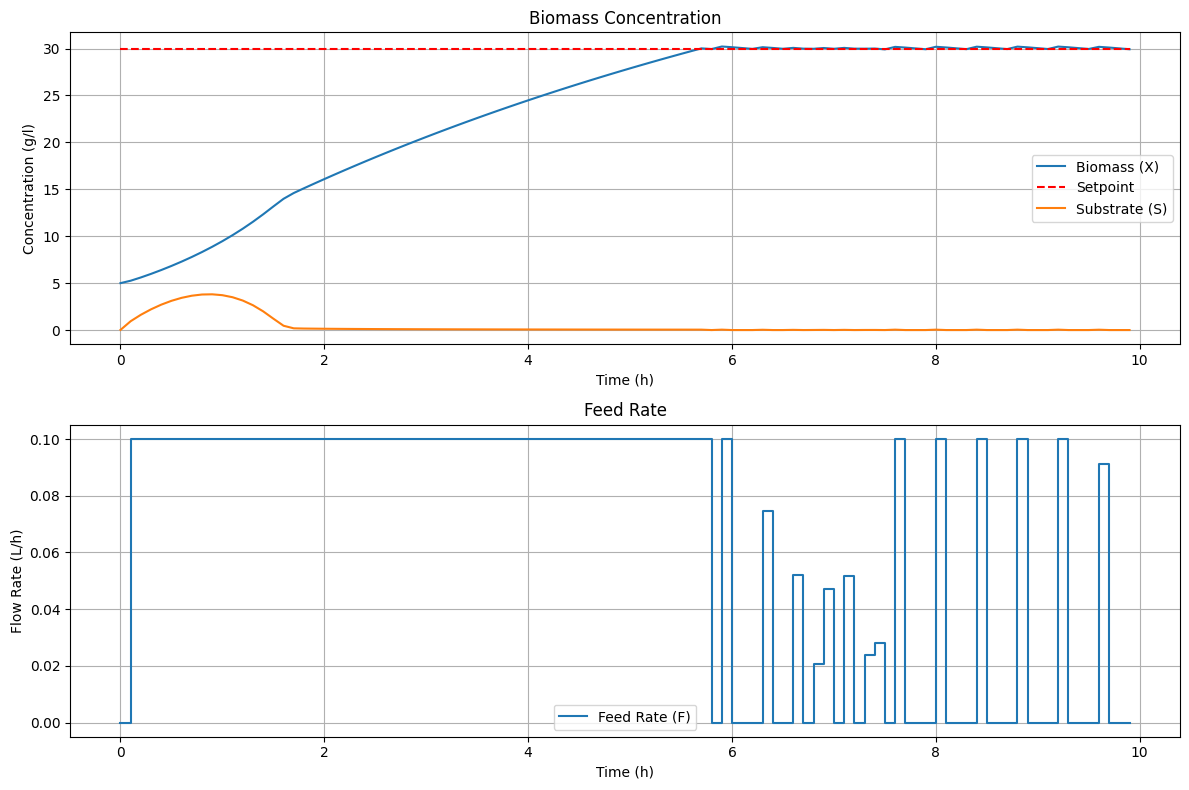

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(t_hist, X_hist, label='Biomass (X)')
plt.plot(t_hist, [setpoint]*len(t_hist), 'r--', label='Setpoint')
plt.plot(t_hist, S_hist, label='Substrate (S)')
plt.title('Biomass Concentration')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.step(t_hist, F_hist, label='Feed Rate (F)', where='post')
plt.title('Feed Rate')
plt.xlabel('Time (h)')
plt.ylabel('Flow Rate (L/h)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
